In [1]:
#Loading the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Loading the dataset
path = 'california_housing_train.csv'
raw_df = pd.read_csv(path)

In [3]:
#Viewing the dataset
raw_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [4]:
#Creating a copy of the dataframe to work with
df = raw_df.copy()

## Task - Write a function in python that take dataframe as input and *Smartly* drop columns having Pearson correlation more than 0.95

In [5]:
#Method to view heatmap of a correlation matrix dataframe
def heatMap(df):
  upper = df.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))         #Creating dataframe out of the upper triangle of the correlation matrix
  plt.figure(figsize = (20, 15))
  s = sns.heatmap(upper,
                   annot = True, 
                   cmap = 'RdYlGn',
                   vmin = -1, 
                   vmax = 1)
  s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
  s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
  plt.title('Correlation Heatmap')
  plt.show()

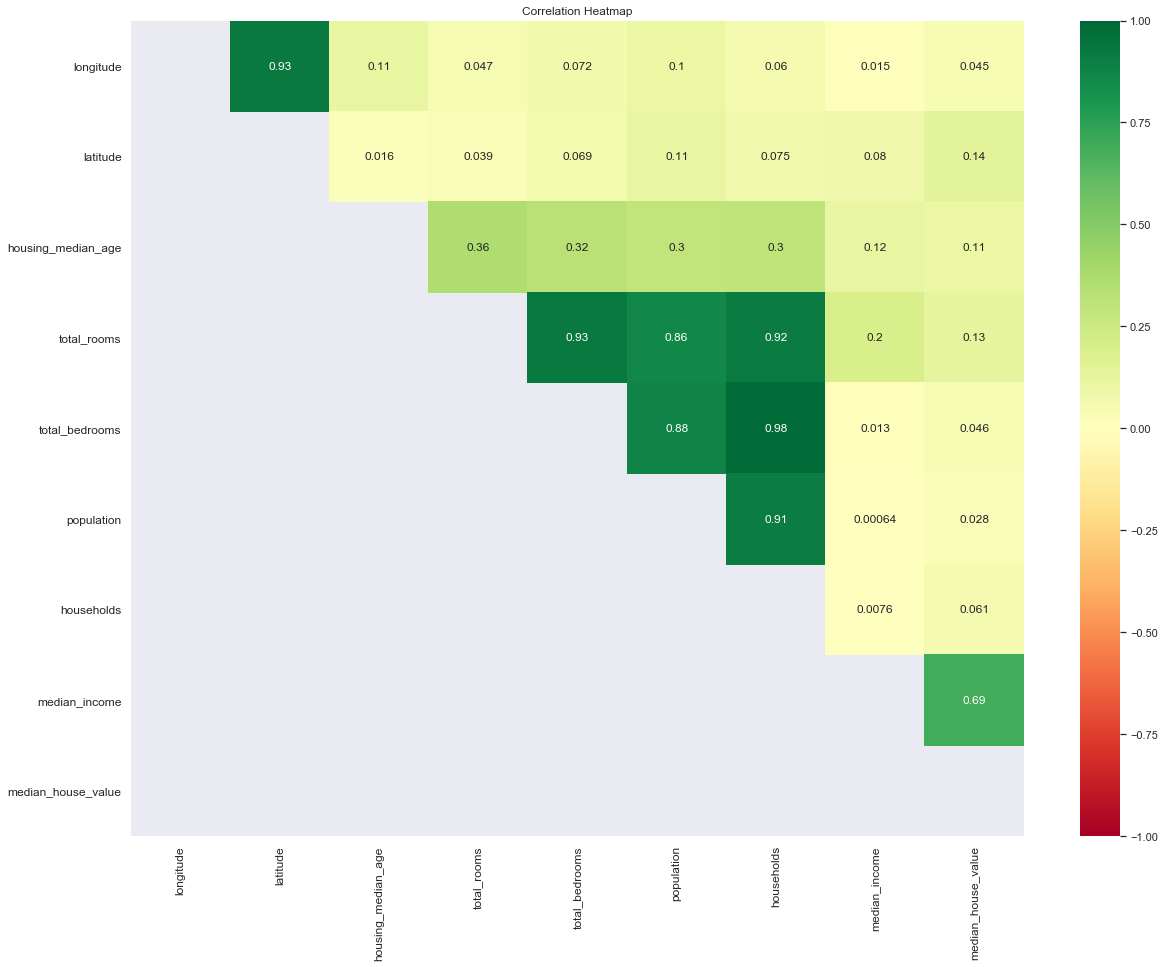

In [6]:
#Viewing the correlation matrix at the start
startCorrMatrix = df.corr(method='pearson', min_periods=30).abs()
#Calling method to display the heatmap
heatMap(startCorrMatrix)

In [7]:
#Method to create the variance inflation factor DataFrame
def vif(df):
  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  vif["features"] = df.columns
  vif.sort_values(by = ["VIF Factor"], ascending=False, inplace = True)
  return vif

In [8]:
#Viewing the variance inflation factor
df_vif = vif(df)
df_vif

,VIF Factor,features
0,628.104059,longitude
1,565.859443,latitude
6,97.547879,households
4,97.190909,total_bedrooms
3,30.539308,total_rooms
5,17.594014,population
7,15.276260,median_income
8,10.073108,median_house_value
2,7.827488,housing_median_age


In [9]:
#Feature selection class to eliminate multicollinearity
class MultiCollinearityEliminator():
    
    #Class Constructor
    def __init__(self, df, target, threshold):
        self.df = df
        self.target = target
        self.threshold = threshold

    #Method to create and return the feature correlation matrix dataframe
    def createCorrMatrix(self, include_target = False):
        #Checking we should include the target in the correlation matrix
        if (include_target == False):
            df_temp = self.df.drop([self.target], axis =1)
            
            #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
            #Setting min_period to 30 for the sample size to be statistically significant (normal) according to 
            #central limit theorem
            corrMatrix = df_temp.corr(method='pearson', min_periods=30).abs()
        #Target is included for creating the series of feature to target correlation - Please refer the notes under the 
        #print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
        return corrMatrix

    #Method to create and return the feature to target correlation matrix dataframe
    def createCorrMatrixWithTarget(self):
        #After obtaining the list of correlated features, this method will help to view which variables 
        #(in the list of correlated features) are least correlated with the target
        #This way, out the list of correlated features, we can ensure to elimate the feature that is 
        #least correlated with the target
        #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity
        
        #Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target = True)                           
        #Creating the required dataframe, then dropping the target row 
        #and sorting by the value of correlation with target (in asceding order)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)                    
        print(corrWithTarget, '\n')
        return corrWithTarget

    #Method to create and return the list of correlated features
    def createCorrelatedFeaturesList(self):
        #Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        #Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            #Iterating through the values (row wise) of the correlation matrix dataframe
            for idx, row in corrMatrix.iterrows():                                            
                if(row[column]>self.threshold) and (row[column]<1):
                    #Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        print(colCorr, '\n')
        return colCorr

    #Method to eliminate the least important features from the list of correlated features
    def deleteFeatures(self, colCorr):
        #Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        for idx, row in corrWithTarget.iterrows():
            print(idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis =1)
                break
        return self.df

    #Method to run automatically eliminate multicollinearity
    def autoEliminateMulticollinearity(self):
        #Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            #Obtaining the dataframe after deleting the feature (from the list of correlated features) 
            #that is least correlated with the taregt
            self.df = self.deleteFeatures(colCorr)
            #Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df

In [10]:
#Instantiating the custom made class to eliminate multicollinearity
#Considering household to be the target 
multiCollinearityEliminator = MultiCollinearityEliminator(df, 'households', 0.9)

In [11]:
#Calling the method to eliminate multicollinearity and storing the preprocessed data frame
df_preprocessed = multiCollinearityEliminator.autoEliminateMulticollinearity()

['latitude', 'longitude', 'total_bedrooms', 'total_rooms'] 

                    households
median_income         0.007644
longitude             0.059628
median_house_value    0.061031
latitude              0.074902
housing_median_age    0.302754
population            0.909247
total_rooms           0.919018
total_bedrooms        0.980920 

median_income 

longitude 

['total_bedrooms', 'total_rooms'] 

                    households
median_income         0.007644
median_house_value    0.061031
latitude              0.074902
housing_median_age    0.302754
population            0.909247
total_rooms           0.919018
total_bedrooms        0.980920 

median_income 

median_house_value 

latitude 

housing_median_age 

population 

total_rooms 

[] 



Here as you can see, from the **list of correlated features** and from the series of **feature to target correlation** *(the first and second print)*

we first check if the feature that is least correlated to target is present in the list of correlated features, if yes we delete this feature from the data frame, if not we check the 2nd feature that is least correlated to target and so on.
*(the third and fourth print)*

We continue this checking and deleting till there are no more correlated features
*(till the last print)*

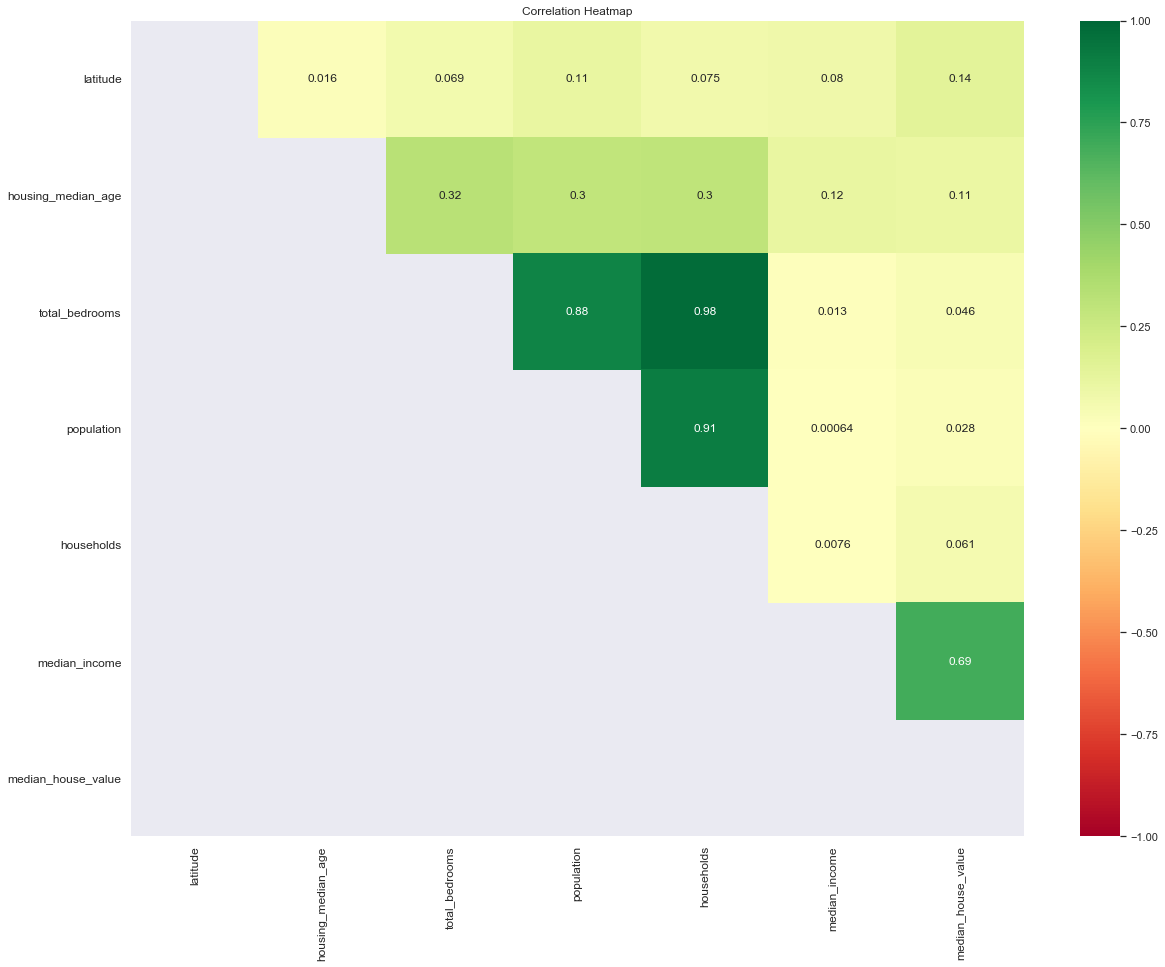

In [12]:
#Viewing the correlation matrix after preprocessing
finalCorrMatrix = df_preprocessed.corr(method='pearson', min_periods=30).abs()
#Calling method to display the heatmap
heatMap(finalCorrMatrix)

We have eliminated longitude and total_rooms to eliminate multicollinearity beyond the threshold of 0.9

The autoML class has eliminated the least number and the least important features to eliminate multicollinearity in the data set above. The class has also ensured to not eliminate the features that are highly correlated with the target with a simple if else condition while creating the correlation matrix.